# Проектная работа

**Цель** - Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. Гипотезы для увеличения выручки были подготовлены совместно с отделом маркетинга.

##  Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
import scipy.stats as stats

pd.options.display.max_colwidth = 130

## Задание пользовательских функций

In [2]:
def df_check(df):
    # функция для проверки количества дубликатов в датафрейме 
    # и количества пропусков по столбцам
    print(f'Количество дубликатов в датафрейме равно {df.duplicated().sum()}')
    print('Пропуски в датафрейме:')
    print(df.isna().sum())

## Загрузка и подготовка данных

In [3]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

### Датасет hypothesis

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
hypothesis.sample(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10


В таблице **hypothesis** содержатся следующие данные:
1. **Hypothesis** - краткое описание гипотезы, формат object
2. **Reach** - охват пользователей по 10-балльной шкале, формат int64 
3. **Impact** - влияние на пользователей по 10-балльной шкале, формат int64 
4. **Confidence** - уверенность в гипотезе по 10-балльной шкале, формат int64
5. **Efforts** - затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы, формат object

Всего в датасете 5 столбцов и 9 строк, из info видно что пропуски и дубликаты отсутствуют, но на всякий случай проведем проверку. Для этого воспользуемся функцикией проверки df_check.

In [6]:
# вызов функции для проверки на дубликаты и пропуски
df_check(hypothesis)

Количество дубликатов в датафрейме равно 0
Пропуски в датафрейме:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


Итого в датасете **hypothesis** отсутствуют дупликаты и пропуски. Форматы данных также нас устраивают. Осталось только привести названия столбцом к формату snake_case, убрав верхний регистр c помощью метода str.lower(). 

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Датасет orders

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
1143,3551685910,2397025226,2019-08-13,910,B
344,2161369048,130417038,2019-08-03,1530,A
1187,2274188238,132143192,2019-08-14,750,A
801,504373597,2604012846,2019-08-05,890,B
751,348143148,689129267,2019-08-20,37150,B


В таблице **orders** содержатся следующие данные:
1. **transactionId** - идентификатор заказа, формат int64
2. **visitorId** - идентификатор пользователя, совершившего заказ, формат int64 
3. **date** - дата, когда был совершён заказ; формат object 
4. **revenue** - выручка заказа, формат int64
5. **group** - группа A/B-теста, в которую попал заказ, формат object

Всего в датасете 5 столбцов и 1197 строк, из info видно что пропуски и дубликаты отсутствуют, но на всякий случай проведем проверку. Для этого воспользуемся функцикией проверки df_check.

In [10]:
# вызов функции для проверки на дубликаты и пропуски
df_check(orders)

Количество дубликатов в датафрейме равно 0
Пропуски в датафрейме:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


Итого в датасете **orders** отсутствуют дупликаты и пропуски. Приведем названия столбцов **transactionId**, **visitorId** к формату snake_case

In [11]:
# Приведение названий столбцов к формату snake_case
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

Также приведем столбец **date** с датой совершения заказа к нужному формату


In [12]:
# преобразование даты к формату datetime64[ns]
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Датасет visitors

In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
visitors.sample(5)

,date,group,visitors
39,2019-08-09,B,610
16,2019-08-17,A,412
52,2019-08-22,B,650
26,2019-08-27,A,711
46,2019-08-16,B,413


В таблице **visitors** содержатся следующие данные:

1. **date** - дата, формат object
2. **group** -  группа A/B-теста, формат object
3. **visitors** - количество пользователей в указанную дату в указанной группе A/B-теста, формат int64

Всего в датасете 3 столбца и 62 строки, из info видно что пропуски и дубликаты отсутствуют, но на всякий случай проведем проверку. Для этого воспользуемся функцикией проверки df_check.

In [15]:
# вызов функции для проверки на дубликаты и пропуски
df_check(visitors)

Количество дубликатов в датафрейме равно 0
Пропуски в датафрейме:
date        0
group       0
visitors    0
dtype: int64


Пропусков и дубликатов нет, названия столбцов нас устраивают, осталось только привести столбец с датой к нужному формату

In [16]:
# преобразование даты к формату datetime64[ns]
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Вывод


Все три датафрейма **hypothesis**, **orders**, **visitors** были проанализированы. Проблем с данными не обнаружено. Столбцы с датами были приведены к нужному формату, заголовки были отформатированы (в формат snake_case).

## Приоритизация гипотез

### Приоритизация гипотез с помощью фреймворка ICE 

Одним из самых популярных способов приоритизации задач перед проведением A/B теста является фреймворк ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота»). Ниже приведена формула расчета. 

$$ ICE = IMPACT * CONFIDENCE * EASE =  \cfrac{IMPACT * CONFIDENCE}{EFFORTS} $$


Где 
- **Impact** — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта,
- **Confidence** — насколько вы уверены, что это изменение повлияет на пользователей именно так,
- **Efforts** — сколько стоит протестировать эту гипотезу.

Применим фрейморк к нашим данным.

In [17]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


По модели приоритизации гипотез ICE можно сделать вывод, что наиболее перспективные для проверки :
- **Гипотеза 8** - Запустить акцию, дающую скидку на товар в день рождения (ICE 16.2)
- **Гипотеза 0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (ICE 13.3)
- **Гипотеза 7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ICE 11.2)

Менее перспективные гипотезы:
- **Гипотеза 4** - Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей (ICE 1)
- **Гипотеза 3** - Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар (ICE 1.12)
- **Гипотеза 5** - Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов (ICE 1.33)

### Приоритизация гипотез с помощью фреймворка RICE 

Приоритизируем гипотезы используя модифицированный метод RICE:

$$ RICE = REACH * IMPACT * CONFIDENCE * EASE =  \cfrac{REACH * IMPACT * CONFIDENCE}{EFFORTS} $$

Где добавленный параметр **Reach** — скольких пользователей затронет изменение, которое вы хотите внести,

In [18]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


На первое место вышла **гипотеза 7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, причем отрыв от следующей гипотезы в 2 раза больше, значит охват привлеченных изменением пользователей оценен как очень большой.

На втором месте идет **гипотеза 2** - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Далее идет **гипотеза 0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 

И лишь на четвертом месте идет лидер по приоритизации ICE - **гипотеза 8** - Запустить акцию, дающую скидку на товар в день рождения.

Топ 3 менее важных гипотез по RICE - **гипотеза 4, гипотеза 5, гипотеза 1**

Поскольку метод RICE отличается от ICE параметром **Reach** , отвечающих за количество пользователей, на которое повлияет изменения, то понятно, почему **гипотеза 7** "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" вышла на первое место. Такое изменение действительно затронет всех пользователей, зашедших на основную страницу, и его Reach будет очень большим. Аналогично с **гипотезой 8** - "Запустить акцию, дающую скидку на товар в день рождения". Несмотря на то, что по методу ICE гипотеза имеет наивысший приоритет, она повлияет лишь на пользователей, у которых день рождение в день покупки. Это достаточно маленькая часть от всех пользователей, поэтому параметр Reach у нее невысок. 

### Вывод

In [19]:
pal = sns.light_palette("purple", as_cmap=True)
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by=['ICE','RICE'], ascending=False).style.background_gradient(cmap=pal)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


1. По модели приоритизации гипотез ICE можно сделать вывод, что наиболее перспективные для проверки :
- **Гипотеза 8** - Запустить акцию, дающую скидку на товар в день рождения (ICE 16.2)
- **Гипотеза 0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (ICE 13.3)
- **Гипотеза 7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ICE 11.2)

Менее перспективные гипотезы:
- **Гипотеза 4** - Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей (ICE 1)
- **Гипотеза 3** - Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар (ICE 1.12)
- **Гипотеза 5** - Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов (ICE 1.33)

2. По модели RICE  На первое место вышла **гипотеза 7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, причем отрыв от следующей гипотезы в 2 раза больше, значит охват привлеченных изменением пользователей оценен как очень большой (RICE 112).
- На втором месте идет **гипотеза 2** - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (RICE 56).
- Далее идет **гипотеза 0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (RICE 40).
- И лишь на четвертом месте идет лидер по приоритизации ICE - **гипотеза 8** - Запустить акцию, дающую скидку на товар в день рождения (RICE 40).
Топ 3 менее важных гипотез по RICE - **гипотеза 4 (RICE 3), гипотеза 5 (RICE 4), гипотеза 1 (RICE 4)**

3. Поскольку метод RICE отличается от ICE параметром **Reach** , отвечающих за количество пользователей, на которое повлияет изменения, то понятно, почему **гипотеза 7** "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" вышла на первое место. Такое изменение действительно затронет всех пользователей, зашедших на основную страницу, и его Reach будет очень большим. Аналогично с **гипотезой 8** - "Запустить акцию, дающую скидку на товар в день рождения". Несмотря на то, что по методу ICE гипотеза имеет наивысший приоритет, она повлияет лишь на пользователей, у которых день рождение в день покупки. Это достаточно маленькая часть от всех пользователей, поэтому параметр Reach у нее невысок. 

## Анализ A/B-теста

В датасетах **orders, visitors** хранятся результаты проведенного A/B теста. Проанализируем их.

    Для начала проверим сколько пользователей вошли в каждую группу

In [20]:
print('Количество пользователей в группе А равно', orders[orders['group'] == 'A']['visitor_id'].count())
print('Количество пользователей в группе В равно', orders[orders['group'] == 'B']['visitor_id'].count())

Количество пользователей в группе А равно 557
Количество пользователей в группе В равно 640


в "идеальном" A/B тесте количество людей в выборках жолжно быть одинаково, или по крайней мере различие не более чем 0.5 %. Мы видим, что в наших данных другое соотношение. Возможно это следует учитывать при интерпретации результатов.

Так как при проведении A/B теста группы должны быть независимы, проверим данные на пересечение

In [21]:
n_users = orders.groupby('visitor_id')['group'].nunique().sort_values(ascending=False)
print('Количество пользователей, попавших в обе группы равно', (n_users == 2).sum())

Количество пользователей, попавших в обе группы равно 58


Итого, в датасете присутствует 58 visitor_id, которые попали в обе группы исследования. Важным условием успешного A/B теста является уникальность выборок, возможно это следует учитывать при интерпретации результатов.

Будем работать с кумулятивными (накопленными) значениями. 

Создаим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates().

In [22]:
datesGroups = orders[['date','group']].drop_duplicates() 

Создаем переменную с кумулятивными значениями для выручки **ordersAggregated**, содержащую:
1. дату
2. группу A/B-теста;
3. число уникальных заказов в группе теста по указанную дату включительно;
4. число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
5. суммарную выручку заказов в группе теста по указанную дату включительно;
И отсортируем ее по дате и группе

In [23]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] ==
    x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 
                      'visitor_id' : 'nunique', 'revenue' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

Объявите переменную **visitorsAggregated**, содержащую:
1. дату;
2. группу A/B-теста;
3. количество уникальных посетителей в группе теста по указанную дату включительно;
И отсортируем ее по дате и группе

In [24]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] ==
     x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

И объеденим их, создав наш массив кумулятивных данных для анализа

In [25]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Анализ графика кумулятивной выручки по группам 

In [26]:
# создание групп для расчета кумулятивной выручки по группам
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

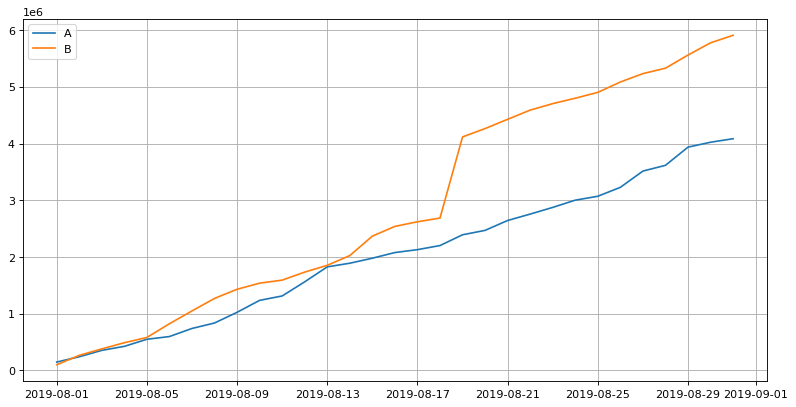

In [27]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.grid()

По графику кумулятивной выручки по группам видно, что сегмент B почти сразу вышел вперед, однако разница была маленькая ( 13 августа она даже почти равнялась нулю). Однако 17 августав сегменте В произошел резкий скачок, и начиная с этой даты кумулятивная выручка сегмента B стала больше кумулятивной выручки сегмента A приблизительно на треть. Данный скачок может говорить о резком росте числа заказов, либо о появлении очень дорогих заказов в выборке.

### Анализ графика кумулятивного среднего чека по группам

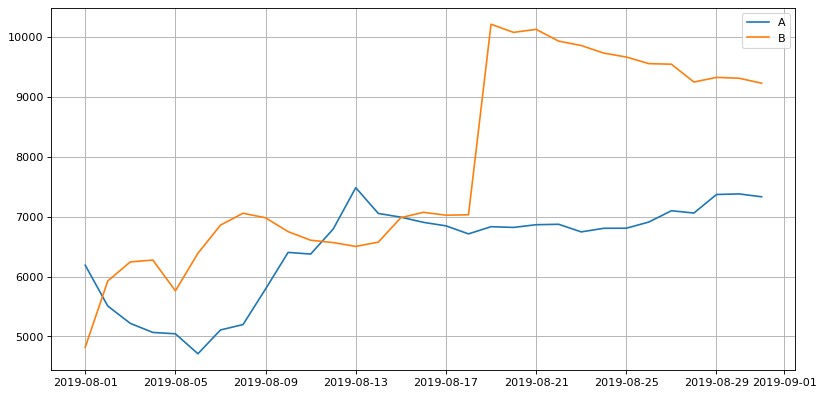

In [28]:
# строим графики кумулятивного среднего чека
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.grid()

По графику кумулятивного среднего чека по группам мы видим, что сегмент B почти всегда был лучше сегмента А, кроме небольшого промежутка приблизительно с 11 по 15 августа. Затем в районе 18 августа снова заметен резкий рост среднего чека сегмента B. 
Затем средний чек группы B плавно пошел на спад, а группы A снова начал плавно возрастать после 23 августа. 
В целом результаты еще не до конца стабилизировались: чек относительно установился для группы A, а для группы В продолжает падать после резкого скачка. Вероятно нужно больше времени чтобы прийти к реальному значению среднего чека. 

### Анализ графика относительного изменения кумулятивного среднего чека группы B к группе A

Объеденим таблицы cumulativeRevenueA и cumulativeRevenueB методом merge() и построим график относительного изменения кумулятивного среднего чека группы B к группе A 

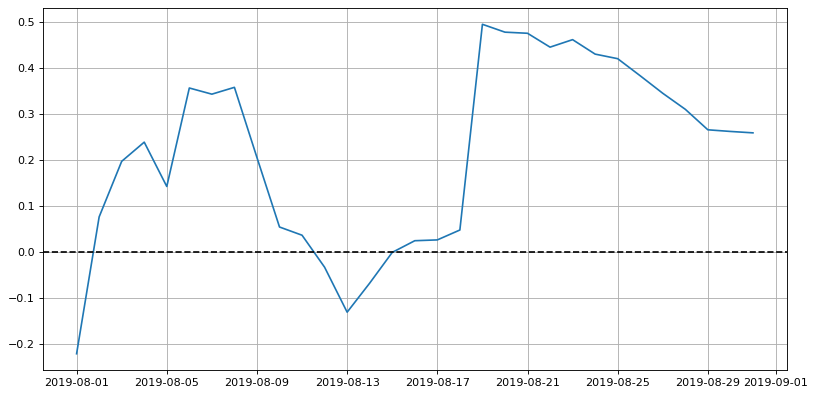

In [29]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left',
                          suffixes=['A', 'B'])

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) /
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.grid()

На графике относительного изменения кумулятивного среднего чека группы B к группе A видны резкие скачки. Вероятно это связано с выбросами и аномальными значениями данных. Скорее всего аномальные заказыы были совершены в даты "скачков" на графике

### Анализ графика кумулятивной конверсии по группам

Добавим расчет конверсии в наши данные и посмотрим на графики конверсии по группам

In [30]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

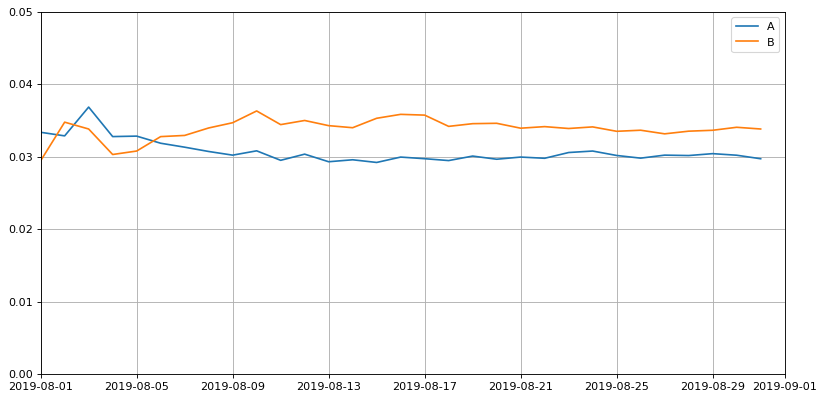

In [31]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]) 
plt.grid()

Из графиков кумулятивной конверсии по группам видно, что в начале теста был промежуток, когда сегмент А имел большую конверсию, однако начиная с 6 августа конверсия группы B вышла вперед и была выше на протяжении всего теста. Конверсии обеих групп выровнились и конверсия группы B стабильно выше конверсии группы A на пол процента. 

### Анализ  графика относительного изменения кумулятивной конверсии группы B к группе A

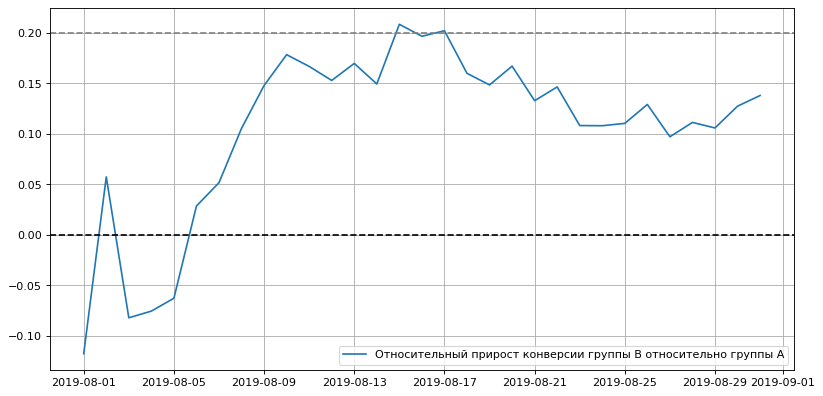

In [32]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                              left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
    mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.grid()
#plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])

Анализируя график относительного изменения кумулятивной конверсии группы B к группе A мы видим, что конверсия не зафиксировалась на одном уровне. В начале теста был промежуток проигрыша группе А, затем резкий рост до значения прироста 20 %, однако затем спал к 10% и более плавное увеличение к 15 %. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. 

### Анализ точечного графика количества заказов по пользователям

Cоздадим датафрейм cо столбцами: 'user_id' и 'orders' - количество заказов по пользователям

In [33]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', 
                as_index=False).agg({'transaction_id':'nunique'}).sort_values(by='transaction_id', ascending=False)  
ordersByUsers.columns = ['user_id', 'orders']

Построим гистаграмму и диаграмму рассеяния для количества заказов по пользователем

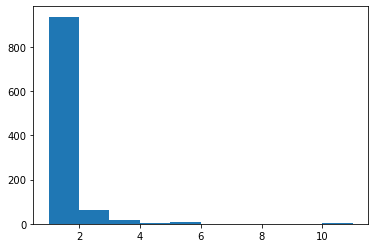

In [34]:
plt.hist(ordersByUsers['orders']) 
plt.show()

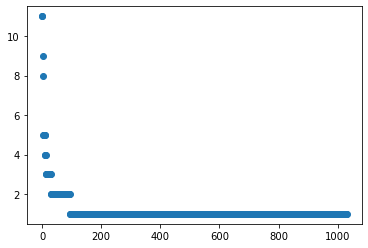

In [35]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 

По гистограмме и точечной диаграмме видно, что людей с 4 и более заказами совсем мало, однако попадаются люди с более чем 10 заказами. Осталось понять, какие значени считать выбросами: более 2 или более 4 заказов.

### Рассчет 95-го и 99-го перцентиля количества заказов на пользователя и определение границы аномальных пользователей

In [36]:
# рассчет перцентилей
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Мы видим что менее 5 % пользователей заказало больше 2-х заказов, а менее 1 % заказало более 4-х заказов. Было решено выбрать 4 и более заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Анализ точечного графика и гистограммы стоимостей заказов

Построим гистограмму и диаграмму рассеяния распределения стоимости по заказам

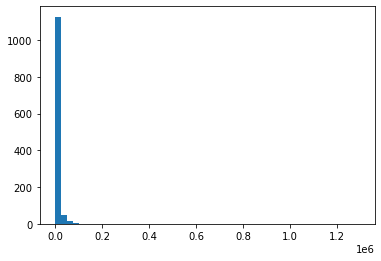

In [37]:
plt.hist(orders['revenue'], bins=50) 
plt.show()

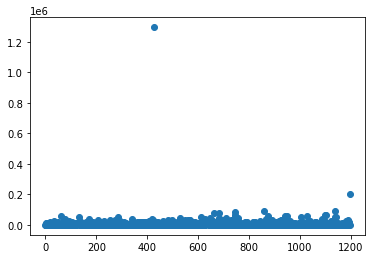

In [38]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

Гистограмма оказалось не самой информативной, видно что почти все значения находятся в пределах 100 000. По диаграмме рассеяния также видно мало аномальных заказов: сильно выбивающееся значение в 1.3 миллиона и значение в районе 200 000. Проверим перцентили. Ограничим оси чтобы поближе посмотреть на распределение

(0.0, 100000.0)

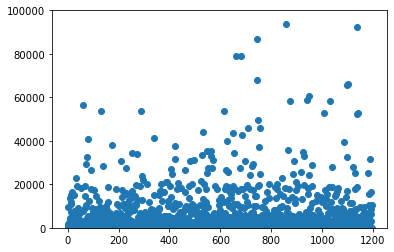

In [39]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)

По диаграмме рассеяния в y-масштабе от 0 до 100 000 видно, что основное облако точек сосредоточено в области до 20 000, начиная с 60 000 частота встречи заказов становится совсем редкой

###  Рассчет 95-го и 99-го перцентиля стоимости заказов и определение границы аномальных пользователей

In [40]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5 % пользователей совершили закасы стоимостью более 28 000, не более одного процента пользователей совершили заказы на сумму более 58 000. Примем за аномальные значения заказы больше 95 перцентиля, так как мы видим, что выбросы достаточно редки по сравнению с общей частью. 

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным 

**Нулевая гипотеза:** различий в конверсии между группами нет. 
**Альтернативная:** различия в конверсии между группами есть.

Сначала подготовим данные

In [41]:
# создание датафреймов с кумулятивным количеством посещений в разные даты по группам
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)


visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)

In [42]:
# создание датафреймов с кумулятивным количеством заказов в разные даты по группам

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]


Объеденим полученные кумулятивные данные в один датафрейм

In [43]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left', suffixes=('', '_delme')
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left', suffixes=('', '_delme'))
)
data = data[[c for c in data.columns if not c.endswith('_delme')]]
data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707


Посчитаем статистическую значимость различия в конверсии между группами. Для этого создадим переменные, в которых будет указано число совершенных заказов для пользователей, которые заказывали хотя бы 1 раз

In [44]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders'] 

Создадим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.  Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни. Тем кто ничего не заказал будут соответствовать нули. 

In [45]:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - 
                                        len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - 
                                        len(orders_by_users_b['orders'])), name='orders')],axis=0)

Число элементов sample — это количество пользователей, сумма всех элементов — количество заказов. Получим конверсии по группам, поделив сумму заказов на число пользователей

In [46]:
if stats.mannwhitneyu(sample_a, sample_b)[1] < 0.05:
    print('p_value равно', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
    print('отвергаем нулевую гипотезу')
else:
    print('p_value равно', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
    print('Не получилось отвергнуть нулевую гипотезу')
print('относительный прирост конверсии группы B к группе A равен', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p_value равно 0.008
отвергаем нулевую гипотезу
относительный прирост конверсии группы B к группе A равен 0.138


Мы получили p_value меньше 0.05 - значит отвергаем нулевую гипотезу - различий в конверсии между группами нет.
Принимаем альтернативную гипотезу - **азличия в конверсии между группами есть**. Относительный прирост конверсии группы B к группе A равен 0.138. Данные факты доказывают, что выборки имеют статистически значимые различия. 

### Анализ статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза:** различий в средних чеках между группами нет. 
**Альтернативная:** различия в средних чеках между группами есть.

In [47]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


In [48]:
if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < 0.05:
    print('p_value равно', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
           orders[orders['group']=='B']['revenue'])[1]))
    print('отвергаем нулевую гипотезу')
else:
    print('p_value равно', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
           orders[orders['group']=='B']['revenue'])[1]))
    print('Не получилось отвергнуть нулевую гипотезу')
print('Относительное различие среднего чека межлу группами равно',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p_value равно 0.365
Не получилось отвергнуть нулевую гипотезу
Относительное различие среднего чека межлу группами равно 0.259


p-value значительно больше 0.05, значит не отвергаем нулевую гипотезу: **статистически значимых отличий в средних чеках между группами нет**
Относительное различие среднего чека между группами составило 26 % - средний чек группы B значительно выше среднего чека группы А.


### Анализ статистической значимости различий в конверсии между группами по «очищенным» данным

Раннее было принято решение принять за аномальные данные пользователей с более чем 3 заказами, и пользователей с заказами на сумму выше 58000 рублей.

In [49]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 3]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 3]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.shape)
abnormal_users.head(5)

(63,)


1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64

Всего 20 аномальных пользователей. Посчитаем статистическую значимость различий в конверсии между группами теста по данным без аномальных пользователей.

In [50]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [51]:
if stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1] < 0.05:
    print('p_value равно', "{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
    print('отвергаем нулевую гипотезу')
else:
    print('p_value равно', "{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
    print('Не получилось отвергнуть нулевую гипотезу')
print('относительный прирост конверсии группы B к группе A равен', 
      '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p_value равно 0.009
отвергаем нулевую гипотезу
относительный прирост конверсии группы B к группе A равен 0.148


Как и в случае данных с аномалиями мы отвергаем нулевую гипотезу - статистическая значимость достигнута. 
Относительный прирост конверсии группы B к группе A  при использовании чистых данных увеличился на процент 

### Анализ статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Проверим, появилась ли статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [52]:
p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
if p_value < 0.05:
    
    print('p_value равно', p_value)
    print('отвергаем нулевую гипотезу')
else:
    print('p_value равно', p_value)
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('относительный прирост конверсии группы B к группе A равен',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p_value равно 0.48826464606271097
Не получилось отвергнуть нулевую гипотезу
относительный прирост конверсии группы B к группе A равен -0.017


По очищенным данным среднего чека мы получили статистическую значимость! Это значит, что после удаления выбросов в данных стало меньше шума, снизилась дисперсия. Однако вместо прироста в группе B наблюдается падение среднего чека. 

## Общий вывод

1. Перед началом расчетов и анализа была проведена предобработка данных: все три датафрейма **hypothesis**, **orders**, **visitors** были проанализированы. Проблем с данными (пропуски и явные дубликаты) не обнаружено. Столбцы с датами были приведены к нужному формату, заголовки были отформатированы (в формат snake_case).

2. Затем была проведена приоритизация гипотез методами **ICE**, **RICE**
    - По модели приоритизации гипотез ICE можно сделать вывод, что наиболее перспективные для проверки : **Гипотеза 8** (ICE 16.2), **Гипотеза 0** (ICE 13.3), **Гипотеза 7** (ICE 11.2). Наименее перспективные гипотезы: **Гипотеза 4** (ICE 1), **Гипотеза 3** (ICE 1.12), **Гипотеза 5** (ICE 1.33). 
    - По модели RICE  На первое место вышла **гипотеза 7** (RICE 112), на втором месте идет **гипотеза 2** (RICE 56), далее идет **гипотеза 0** (RICE 40). И лишь на четвертом месте идет лидер по приоритизации ICE - **гипотеза 8**
    - Данное отличие по методам приоритизации связано с параметром **Reach** метода RICE, отвечающего за количество пользователей, на которое повлияет изменения. Поэтому **гипотеза 7**: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" -  вышла на первое место. Такое изменение действительно затронет всех пользователей, зашедших на основную страницу, и его Reach будет очень большим. Аналогично с **гипотезой 8** - "Запустить акцию, дающую скидку на товар в день рождения". Несмотря на то, что по методу ICE гипотеза имеет наивысший приоритет, она повлияет лишь на пользователей, у которых день рождение в день покупки. Это достаточно маленькая часть от всех пользователей, поэтому параметр Reach у нее невысок. 

3. Затем был проведен анализ результатов A/B теста
    - Было выяснено, что выборки наших групп не делятся идеально 50 на 50 : Количество пользователей в группе А составило 557, 
      группе В равно 640. Также были найдены 58 пользователей, учтенных в обеих группах. С одной стороны это маленькая часть от всей выборки, однако при проведении A/B теста очень важно, чтобы все пользователи были уникальными. Было принято решение не удалять этих пользователей, но помнить о том, что они существуют при интерпретации результатов.
    - По графику кумулятивной выручки по группам видно, что сегмент B почти сразу вышел вперед, однако разница была маленькая ( 13 августа она даже почти равнялась нулю). Однако 17 августа в сегменте В произошел **резкий скачок**, и начиная с этой даты кумулятивная выручка сегмента B стала больше кумулятивной выручки сегмента A приблизительно на треть. Данный скачок может говорить о резком росте числа заказов, либо о появлении очень дорогих заказов в выборке.
    - По графику кумулятивного среднего чека по группам мы видим, что сегмент B почти всегда был лучше сегмента А, кроме небольшого промежутка приблизительно с 11 по 15 августа. Затем в районе 18 августа снова заметен резкий рост среднего чека сегмента B. Затем средний чек группы B плавно пошел на спад, а группы A снова начал плавно возрастать после 23 августа. **В целом результаты еще не до конца стабилизировались:** чек относительно установился для группы A, а для группы В продолжает падать после резкого скачка. Вероятно нужно больше времени чтобы прийти к реальному значению среднего чека.
    - На графике относительного изменения кумулятивного среднего чека группы B к группе A видны резкие скачки. Вероятно это связано с выбросами и аномальными значениями данных. **Скорее всего аномальные заказы были совершены в даты "скачков"** на графике
    - Из графиков кумулятивной конверсии по группам видно, что в начале теста был промежуток, когда сегмент А имел большую конверсию, однако начиная **с 6 августа конверсия группы B вышла вперед и была выше на протяжении всего теста**. Конверсии обеих групп выровнились и конверсия группы B стабильно выше конверсии группы A на пол процента.
    - Анализируя график относительного изменения кумулятивной конверсии группы B к группе A мы видим, что **конверсия не зафиксировалась на одном уровне**. В начале теста был промежуток проигрыша группе А, затем резкий рост до значения прироста 20 %, однако затем спал к 10% и более плавное увеличение к 15 %. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.
    - Затем, используя гистограммы, диаграммы рассеяния и расчет перцентилей, были определены "аномальные" заказы и стоимости.  Было решено выбрать **4 и более заказов на одного пользователя за нижнюю границу** числа заказов, и отсеять аномальных пользователей по ней. **Примем за аномальные значения стоимости заказы больше 95 перцентиля (больше 28 000)**, так как мы видим, что выбросы достаточно редки по сравнению с общей частью.
    - Затем мы провели расчет статистической значимости различий в конверсии между группами по «сырым» данным. Мы получили p_value меньше 0.05 (0.017) - значит отвергаем нулевую гипотезу - **статистические различия в конверсии между группами есть**. Относительный прирост конверсии группы B к группе A равен 0.138. Данные факты доказывают, что выборки имеют статистически значимые различия.
    - При расчете статистической значимости различий средних чеков мы получили p-value значительно больше 0.05, значит **статистического различия в среднем чеке между группами нет** Относительное различие среднего чека между группами составило 26 % - средний чек группы B значительно выше среднего чека группы А.
    - **При проверке на статистическую значимость "чистых данных" без аномалий мы снова получили статистическую значимость** и прирост конверсии группы B к группе A (p_value равно 0.018), при этом прирост конверсии группы B к группе A при использовании чистых данных увеличился на процент
    - По сравнению с данными с аномалиями, **по очищенным данным среднего чека мы получили статистическую значимость!** Это значит, что после удаления выбросов в данных стало меньше шума, снизилась дисперсия. Однако вместо прироста в группе B наблюдается падение среднего чека, что немного непонятно для меня, так как группа B лидирует по всем метрикам


Исходя из полученых выводов я бы приняла следующее решение:
    **Несмотря на то, что некоторые метрики (кумулятивный средний чек, кумулятивная конверсия группы B к группе A) еще не до конца стабилизировались, я считаю что тест можно остановить и признать его успешным, так как достигнута статистическая значимость (по чистым данным и для конверсии и для среднего чека) и группы B превосходит группу А по всем признакам**